<a href="http://www.inri.ufsm.br"> 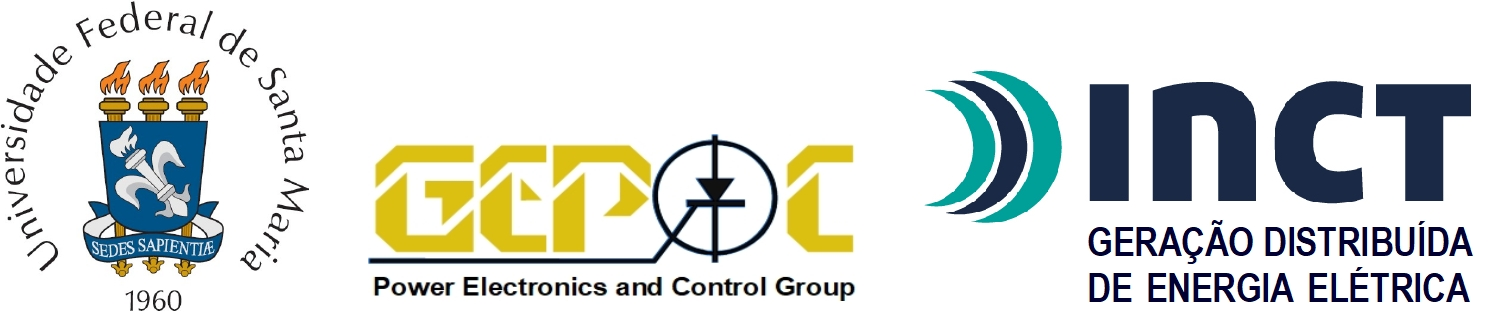 </a>

# Price-Based Power Management (PBPM)


Authors:  Lucas Vizzotto Bellinaso,  Edivan Carvalho, Leandro Michels
<br>Grupo de Eletrônica de Potência e Controle
<br>Instituto de Redes Inteligentes
<br>Universidade Federal de Santa Maria, RS, Brasil


Stored on GitHub: https://github.com/lucasbellinaso/pbpm
<br>Run on Binder: https://mybinder.org/v2/gh/lucasbellinaso/pbpm/master


Previous paper:<br> <a href="https://doi.org/10.1049/iet-rpg.2015.0472">
    L.V. Bellinaso, C. D. Schwertner, L. Michels. Price-based power management of off-grid photovoltaic systems with centralised dc bus. IET Renewable Power Generation. v.10. issue 8. pp 1132-1139. sept 2016.  </a>

## Problem Definition

The Price-Based Power Management is a 

## Price-Response Matrixes (PRMs)


## C code implementation of the PBPM

```c
PRM1 = {0, 1, 2, 2, 2}
PRM2 = {{-2, -1, 1, 2},{},{}}
int main()
{

}
```

Run the code below to set-up the desired system and calculate the Price Response Matrixes of the power elements (i.e. sources, loads and bidirectional).


Quantify power elements of system (i.e. all sources / loads / bidirectional converters):


IntSlider(value=3, continuous_update=False, description='Total count:', max=10, min=1)

Set overall system energy price range (use currency values):



Configure each element individually:


Button(description='Update graph', style=ButtonStyle(button_color='lightgreen'))

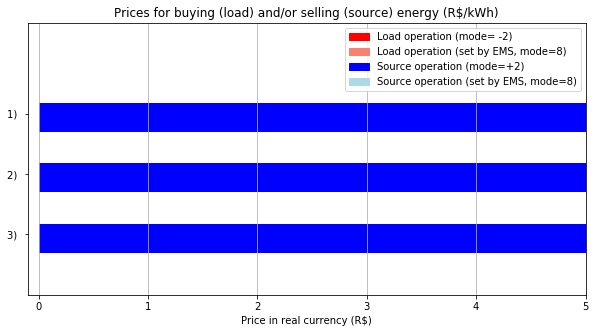

Button(description='Calculate PRMs', style=ButtonStyle(button_color='lightgreen'))

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Label, Layout
from IPython.display import display, clear_output
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Mvf=np.asarray([])
price_vector=np.asarray([])

class Element:
    def __init__(self,name,slb,ctrl,div):
        self.name = name
        self.slb = slb
        self.ctrl = ctrl
        self.div = div
        self.PRM = np.zeros((div,3))
        self.buyprice= list(range(div))
        self.sellprice= list(range(div))
        self.iMR={"Load":np.zeros(6).astype(int),"Source":np.zeros(6).astype(int)}
        self.price_widget = list(range(div))   #stores the number of price widget
        self.a = widgets.Text(placeholder='Set element label', value=self.name, description='Label:',  disabled=False)
        self.b = widgets.ToggleButtons(options=['Source', 'Load', 'Bidirectional'], value=self.slb, description='Power flow:', disabled=False,  button_style='', tooltips=['A source element supplies energy to the DC bus.', 'A load element sinks energy from the DC bus.', 'A bidirectional element is both load and source.'])
        self.c = widgets.ToggleButtons(options=['Controller', 'Not Controller'], description='Control type:', disabled=False,  button_style='', tooltips=['A controller element can control DC bus voltage.', 'A Not Controller element cannot control DC bus voltage.'])
        self.d = widgets.Dropdown(options=['1', '2', '3', '4', '5', '6'],value='1', description='Total count:', disabled=False,layout=Layout(width='15%'))
        self.values_buy = [widgets.BoundedFloatText(value=0,mstep=0.01,description="OC #{}:".format(q+1),disabled=True,layout=Layout(width='60%')) for q in range(div)]
        self.values_sell = [widgets.BoundedFloatText(value=0,mstep=0.01,description="OC #{}:".format(q+1),disabled=False,layout=Layout(width='60%')) for q in range(div)]
        self.values_box = widgets.HBox([widgets.VBox([Label("Max buy price (R$/kWh):"), widgets.VBox(self.values_buy)]), widgets.VBox([Label("Min sell price (R$/kWh):"), widgets.VBox(self.values_sell)])])
        self.a.observe(self.update_properties,'value')
        self.b.observe(self.update_properties,'value')
        self.c.observe(self.update_properties,'value')
        self.d.observe(self.update_properties,'value')
        self.update_flag=False
    def __str__(self):
        return "Name: {0}. Type: {1} {2}. Divisions: {3}\n".format(self.name, self.ctrl, self.slb, self.div)
    def update_properties(self, *args):
        self.name = self.a.value
        self.update_flag=False
        if (self.slb != self.b.value) or (self.div != int(self.d.value)):
            self.update_flag=True
        self.slb = self.b.value
        self.ctrl = self.c.value
        if self.div<int(self.d.value):
            self.values_buy.extend([widgets.BoundedFloatText(value=0,mstep=0.01,description="OC #{}:".format(q+1),disabled=True, layout=Layout(width='60%')) for q in range(self.div,int(self.d.value))])
            self.values_sell.extend([widgets.BoundedFloatText(value=0,mstep=0.01,description="OC #{}:".format(q+1),disabled=False, layout=Layout(width='60%')) for q in range(self.div,int(self.d.value))])
        if self.div>int(self.d.value):
            del self.values_buy[int(self.d.value):self.div]
            del self.values_sell[int(self.d.value):self.div]
        for q in range(int(self.d.value)):
            self.values_buy[q].disabled = True if (self.slb == "Source") else False
            self.values_sell[q].disabled = True if (self.slb == "Load") else False
        self.values_box = widgets.HBox([widgets.VBox([Label("Max buy price (R$/kWh):"), widgets.VBox(self.values_buy)]), widgets.VBox([Label("Min sell price (R$/kWh):"), widgets.VBox(self.values_sell)])])
        self.div = int(self.d.value)
        if self.update_flag==True:
            screen_app.update_screen()
    def set_values(self):
        self.buyprice = [self.values_buy[d].value for d in range(self.div)]
        self.sellprice = [self.values_sell[d].value for d in range(self.div)]   
    def correct_values(self):
        for d in range(self.div):
            self.values_buy[d].min = min_price.value
            self.values_buy[d].max = max_price.value
            self.values_sell[d].max = max_price.value
            self.values_sell[d].min = min_price.value
            if ((self.values_buy[d].value > self.values_sell[d].value)) and (self.slb=="Bidirectional"):
                self.values_buy[d].value = self.values_sell[d].value
    def calculate_PRM(self, colunas):
        self.PRM = (9*np.ones((self.div, colunas))).astype(int)  #init
        MRdict = {"LoadNot Controller":0, "LoadController":-1, "SourceNot Controller":8, "SourceController":1, "BidirectionalController":11, "BidirectionalNot Controller":0}
        MRbefore =  {"LoadNot Controller":8, "LoadController":-2,"SourceController":0,"SourceNot Controller":0,"BidirectionalController":-2,"BidirectionalNot Controller":8}
        MRafter =  {"LoadNot Controller":0, "LoadController":0,"SourceController":2,"SourceNot Controller":8,"BidirectionalController":2,"BidirectionalNot Controller":8}    
        key = self.slb+self.ctrl
        for q in range(self.div):
            if (self.slb != "Bidirectional") or (self.iMR["Load"][q]==self.iMR["Source"][q]):
                iMR = self.iMR["Load"][q] if (self.slb=="Bidirectional") else self.iMR[self.slb][q]
                self.PRM[q,:] = (np.concatenate((MRbefore[key]*np.ones((1,iMR-1)), MRdict[key]*np.ones((1,1)), MRafter[key]*np.ones((1,colunas-iMR))),axis=1)).astype(int)
            else:           #Bidirectional with 5 parts
                iMR1=self.iMR["Load"][q]
                iMR2=self.iMR["Source"][q]
                MR1 = MRdict["Load"+self.ctrl]*np.ones((1,1))
                MR2 = MRdict["Source"+self.ctrl]*np.ones((1,1))
                part1 = MRbefore[key]*np.ones((1,iMR1-1))
                part3 = np.zeros((1,iMR2-iMR1-1))
                part5 = MRafter[key]*np.ones((1,colunas-iMR2)) 
                self.PRM[q,:] = (np.concatenate((part1, MR1, part3, MR2, part5),axis=1)).astype(int)
        
def create_system_matrixes():    
    global Mvf, price_vector
    Mv0=[]
    Mvf=np.asarray([])
    for el_num in range(number.value):   #total elements
        elements[el_num].set_values()  #insert price values in element instances:
        for div in range(elements[el_num].div):
            if elements[el_num].slb is 'Source':
                Mv0.append([elements[el_num].name, el_num+1, elements[el_num].slb, elements[el_num].ctrl,  elements[el_num].div, div+1, 'Source', elements[el_num].sellprice[div]])
            elif elements[el_num].slb is 'Load':
                Mv0.append([elements[el_num].name, el_num+1, elements[el_num].slb, elements[el_num].ctrl,  elements[el_num].div, div+1, 'Load', elements[el_num].buyprice[div]])
            else:
                Mv0.append([elements[el_num].name, el_num+1, elements[el_num].slb, elements[el_num].ctrl,  elements[el_num].div, div+1, 'Source', elements[el_num].sellprice[div]])
                Mv0.append([elements[el_num].name, el_num+1, elements[el_num].slb, elements[el_num].ctrl,  elements[el_num].div, div+1, 'Load', elements[el_num].buyprice[div]])
    Mv1=np.asarray(Mv0)
    Mv1=Mv1[Mv1[:,7].argsort()] ;   #put prices in ascending order
    Nrows = Mv1.shape[0]
    Mvf=np.hstack((Mv1,np.zeros((Nrows,1))))    #increase size of Mvf
    #Defining prices:
    if float(Mvf[0,7]) <= 0 :
        Mvf[0,8] = 0
    else:
        Mvf[0,8] = 1
    for q in range(1,Nrows):     
        #condition1 =  ( Mvf[q,1] != Mvf[q-1,1])   #different element
        #condition2 = (Mvf[q,7] != Mvf[q-1,7])    #different prices
        #condition3 =  ((Mvf[q,3] == "Controller") or (Mvf[q-1,3] == "Controller"))  #one is controller
        #if condition1 and (condition2 or condition3):  # dif. element and (diferent prices or one controller)
        if (   ((Mvf[q,7]!=Mvf[q-1,7])and not((Mvf[q,1]==Mvf[q-1,1])and(Mvf[q,5]!=Mvf[q-1,5]))  )   or   ((Mvf[q,1]!=Mvf[q-1,1]) and (Mvf[q,3]=="Controller") and (Mvf[q-1,3]=="Controller") ) ):
            Mvf[q,8] = int(Mvf[q-1,8])+1
        else:   #equal element or (different element and equal prices and not both controllers)
            Mvf[q,8] = int(Mvf[q-1,8])
    price_vector=np.arange(int(Mvf[0,8])-1,int(Mvf[Nrows-1,8])+1)
    print("Price vector: \n",price_vector,"\n\n")
    for q in range(Nrows):  #update indexes iMR for PRMs inside  elements
        elements[int(Mvf[q,1])-1].iMR[Mvf[q,6]][int(Mvf[q,5])-1]=int(Mvf[q,8])-price_vector[0]+1
    for el_num in range(number.value):
        elements[el_num].calculate_PRM(price_vector.shape[0]) #calculate PRMs
        print(elements[el_num].name,"PRM:\n", elements[el_num].PRM,"\n\n")
        
        
button1 = widgets.Button(description="Update graph")
button1.style.button_color = 'lightgreen'
def on_button1_clicked(b):
    screen_app.update_screen()
button1.on_click(on_button1_clicked)

button2 = widgets.Button(description="Calculate PRMs")
button2.style.button_color = 'lightgreen'
def on_button2_clicked(b):
    screen_app.button2click = True
    screen_app.update_screen()
button2.on_click(on_button2_clicked)
    
    
class Screen_class:
    def __init__(self,x):
        self.x=x
        self.button2click=False
        self.tab=widgets.Tab()
    def update_screen(self):
        clear_output()
        print("Quantify power elements of system (i.e. all sources / loads / bidirectional converters):")
        display(number)
        print("Set overall system energy price range (use currency values):")
        display(widgets.HBox([Label("Overall min price ($/kWh):"),min_price,Label("Overall max price ($/kWh):"),max_price]))
        print("\nConfigure each element individually:")
        self.tab.children = [widgets.VBox([elements[el_num].a, elements[el_num].b,Label("Element can be controlled for dc bus voltage regulation? (Yes = Controller Element;  No = Not Controller Element)"), elements[el_num].c, Label("Quantify the number of possible operational conditions (OC) for this element (i.e. different range of prices):"),elements[el_num].d, elements[el_num].values_box])  for el_num in range(number.value)]
        for i in range(len(self.tab.children)):
            self.tab.set_title(i, "Element {}".format(i+1))
        display(self.tab)
        display(button1)
        for el_num in range(number.value):
            elements[el_num].correct_values()
        update_graphs()
        display(button2)
        if self.button2click is True:
            self.button2click=False
            print("Price Response Matrixes:\n\n")
            create_system_matrixes()


screen_app = Screen_class(0)
elements = [Element("","Source","Controller",1), Element("","Source","Controller",1), Element("","Source","Controller",1)]
number = widgets.IntSlider(value=3, min=1, max=10, step=1, description='Total count:', disabled=False,continuous_update=False, orientation='horizontal', readout=True, readout_format='d')
min_price = widgets.BoundedFloatText(value=-0.1,min=-10,step=0.01,disabled=False,layout=Layout(width='7%'))
max_price = widgets.BoundedFloatText(value=5,min=0,step=0.01,disabled=False,layout=Layout(width='7%'))
def update_min_price(*args):
    max_price.min=min_price.value
def update_max_price(*args):
    min_price.max=max_price.value
def update_element_number(*args):
    if len(elements)>number.value:
        del elements[(number.value):(len(elements)-1)]
    elif len(elements)<number.value:
        for q in range(number.value-len(elements)):
            elements.append(Element("","Source","Controller",1))
    screen_app.update_screen()
min_price.observe(update_min_price, 'value')
max_price.observe(update_max_price,'value')
number.observe(update_element_number,'value')

def update_graphs():
    fig, ax = plt.subplots()
    for el_num in range(number.value):
        ywidth = 6/float(elements[el_num].div)
        if elements[el_num].ctrl == "Controller":
            colors=['red','blue']
        else:
            colors=['salmon', 'lightblue']
        for d in range(elements[el_num].div):
            ypos = (7+10*(number.value-el_num-1)+(elements[el_num].div-d-1)*ywidth)
            if (elements[el_num].slb is "Source") or (elements[el_num].slb is "Bidirectional"):
                xpos = elements[el_num].values_sell[d].value
                ax.broken_barh([(xpos,max_price.value)],(ypos,ywidth*0.8),facecolors=colors[1])
            if (elements[el_num].slb is "Load") or (elements[el_num].slb is "Bidirectional"):
                xpos = elements[el_num].values_buy[d].value-min_price.value
                ax.broken_barh([(min_price.value,xpos)],(ypos,ywidth*0.8),facecolors=colors[0])        
    ax.set_ylim(0, 15+10*(number.value))
    ax.set_xlim(min_price.value, max_price.value)
    ax.set_xlabel('Price in real currency (R$)')
    ax.legend(handles=[mpatches.Patch(color='red', label='Load operation (mode= -2)'), mpatches.Patch(color='salmon', label='Load operation (set by EMS, mode=8)'), mpatches.Patch(color='blue', label='Source operation (mode=+2)'), mpatches.Patch(color='lightblue', label='Source operation (set by EMS, mode=8)')])
    ax.set_yticks([10+10*(number.value-el_num-1) for el_num in reversed(range(number.value))])
    ax.set_yticklabels([str(el_num+1)+') '+elements[el_num].name for el_num in reversed(range(number.value))])
    ax.grid(True,axis='x')
    plt.gcf().set_size_inches(10, 5+0.5*number.value*(number.value>5))
    plt.title('Prices for buying (load) and/or selling (source) energy (R$/kWh)')
    plt.show()
    
screen_app.update_screen()

In [ ]:
(   ((Mvf[q,7]!=Mvf[q-1,7])and not((Mvf[q,1]==Mvf[q-1,1])and(Mvf[q,5]!=Mvf[q-1,5]))  )   or   ((Mvf[q,1]!=Mvf[q-1,1]) and (Mvf[q,3]=="Controller") and (Mvf[q-1,3]=="Controller") ) )
# Mvf(5,c) -> Mvf[q,7]
# Mvf(1,c) -> Mvf[q,1]
# Mvf(2,c) -> Mvf[q,5]
# Mvf(4,c) -> Mvf[q,3]
 #   if (   ((Mvf(5,c)~=Mvf(5,c-1))&~((Mvf(1,c)==Mvf(1,c-1))&(Mvf(2,c)~=Mvf(2,c-1))))|((Mvf(1,c)~=Mvf(1,c-1))& Mvf(4,c)& Mvf(4,c-1) ) )
